# Trying out my own PETSc solver in a notebook environment

In [1]:
from firedrake.petsc import PETSc
import numpy as np
from toy_mlprecon import (ToyMLPreconditioner, Laplace1D, Jacobi, GCR)
import matplotlib.pyplot as plt

In [2]:
def set_ops():
    # Set coefficients in the matrix A and RHS vector B
    A = PETSc.Mat()
    A.create(comm=PETSc.COMM_WORLD)
    A.setSizes([100,100])
    A.setType(PETSc.Mat.Type.PYTHON)
    A.setPythonContext(Laplace1D())
    A.setUp()

    # Set a right-hand side vector
    X, B = A.getVecs()
    # control case: vector of ones
    vec_in = np.ones(100)

    # within dynamic range of training data: superposition of sines
    '''
    matrix = (2*np.eye(102) - np.eye(102, k=-1) - np.eye(102, k=1))*100**2
    xs = np.arange(102, step=1)
    a = 0.1 * 0.3
    b = 0.05 * -0.4
    c = 0.03 * 0.6
    d = 0.03 * -0.5
    vec_out = (a * np.sin(np.pi/100 * xs) + b * np.sin(np.pi/100 * 2 * xs) + 
               c * np.sin(np.pi/100 * 3 * xs) + d * np.sin(np.pi/100 * 4 * xs))
    vec_in = np.dot(vec_out, matrix)
    vec_in = vec_in[1:-1]
    vec_out = vec_out[1:-1]
    '''
    B.setArray(vec_in)

    B_array = B.getArray()
    print("Input RHS vector B:", B_array)

    return A, X, B

def solve_linear_system(A, X, B):
    # Create a linear solver context
    ksp = PETSc.KSP()
    ksp.create(comm=PETSc.COMM_WORLD)
    ksp.setType(PETSc.KSP.Type.PYTHON)
    ksp.setPythonContext(GCR())
    #ksp.setType(PETSc.KSP.Type.GCR)
    ksp.setTolerances(rtol=1e-5)
    #ksp.gcrSetRestart(100)
    ksp.setTolerances(max_it=150)

    # Set the operator (coefficient matrix) for the linear solver
    ksp.setOperators(A, A)
    ksp.setFromOptions()

    #define the pc so PETSc knows what to do when instantiating the ML context
    pc = ksp.getPC()

    # Set the preconditioner for the linear solver
    pc.setType(PETSc.PC.Type.NONE) #for reference runs without pc
    #pc.setType(PETSc.PC.Type.SOR)  #for reference runs with SOR
    #pc.setType(PETSc.PC.Type.PYTHON)
    #pc.setPythonContext(ToyMLPreconditioner())
    #pc.setPythonContext(Jacobi())

    ksp.solve(B, X)

    # Print the solution vector
    X_array = X.getArray()
    print("Solution vector X:", X_array)

    # print error norm
    r = B.duplicate()
    A.mult(X, r)
    r.aypx(-1, B)
    rnorm = r.norm()
    PETSc.Sys.Print('error norm = %g' % rnorm,
                    comm=PETSc.COMM_WORLD)

    # Free resources
    ksp.destroy()
    A.destroy()
    X.destroy()
    B.destroy()

    plt.plot(X_array)
    plt.show()

In [4]:
A, X, B = set_ops()
# Create a linear solver context
ksp = PETSc.KSP()
ksp.create(comm=PETSc.COMM_WORLD)
ksp.setType(PETSc.KSP.Type.PYTHON)
ksp.setPythonContext(GCR())
#ksp.setType(PETSc.KSP.Type.GCR)
ksp.setTolerances(rtol=1e-5)
 #ksp.gcrSetRestart(100)
ksp.setTolerances(max_it=150)

# Set the operator (coefficient matrix) for the linear solver
ksp.setOperators(A, A)
ksp.setFromOptions()

#define the pc so PETSc knows what to do when instantiating the ML context
pc = ksp.getPC()

# Set the preconditioner for the linear solver
pc.setType(PETSc.PC.Type.NONE) #for reference runs without pc
    #pc.setType(PETSc.PC.Type.SOR)  #for reference runs with SOR
    #pc.setType(PETSc.PC.Type.PYTHON)
    #pc.setPythonContext(ToyMLPreconditioner())
    #pc.setPythonContext(Jacobi())

ksp.solve(B, X)

# Print the solution vector
X_array = X.getArray()
print("Solution vector X:", X_array)

# print error norm
r = B.duplicate()
A.mult(X, r)
r.aypx(-1, B)
rnorm = r.norm()
PETSc.Sys.Print('error norm = %g' % rnorm,
                comm=PETSc.COMM_WORLD)

# Free resources
ksp.destroy()
A.destroy()
X.destroy()
B.destroy()

plt.plot(X_array)
plt.show()

Input RHS vector B: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
0
1
-192119201.99999985
2
-192119203.99999994
7.091078973729024e+24
3
-192119203.99999994
7.091078973729024e+24
3.5656356392948084e+74
4
-192119203.99999994
7.091078973729024e+24
3.5656356392948084e+74
4.533262689488557e+223
5
-192119203.99999994
7.091078973729024e+24
3.5656356392948084e+74
4.533262689488557e+223
inf


/Users/GUSTO/environments/firedrake/src/gusto/learning/toy_mlprecon.py:343: RuntimeWarning: overflow encountered in multiply
  self.vv[iv] += -alpha * self.vv[ivj]
/Users/GUSTO/environments/firedrake/src/gusto/learning/toy_mlprecon.py:343: RuntimeWarning: invalid value encountered in multiply
  self.vv[iv] += -alpha * self.vv[ivj]
/Users/GUSTO/environments/firedrake/src/gusto/learning/toy_mlprecon.py:343: RuntimeWarning: invalid value encountered in add
  self.vv[iv] += -alpha * self.vv[ivj]


SystemError: <method 'solve' of 'petsc4py.PETSc.KSP' objects> returned a result with an exception set

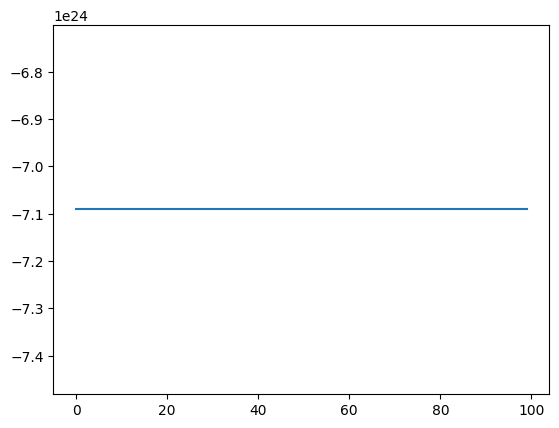

In [23]:
plt.plot(ksp.getPythonContext().ppvv[2])